In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cd ..

/home/anton/rurec


# Download geographic boundaries data
Census [Cartographic Boundary Shapefiles](https://www.census.gov/geo/maps-data/data/tiger-cart-boundary.html)

In [3]:
%%bash
OPWD=`pwd`
for ENTITY in csa cbsa; do
    FILE=cb_2017_us_${ENTITY}_500k.zip
    URL=https://www2.census.gov/geo/tiger/GENZ2017/shp/$FILE
    DIR=data/$ENTITY
    mkdir --parents $DIR
    cd $DIR
    wget --no-clobber --quiet $URL
    7z x $FILE > /dev/null
    cd $OPWD
    echo $FILE done.
done

cb_2017_us_csa_500k.zip done.
cb_2017_us_cbsa_500k.zip done.


# CSA

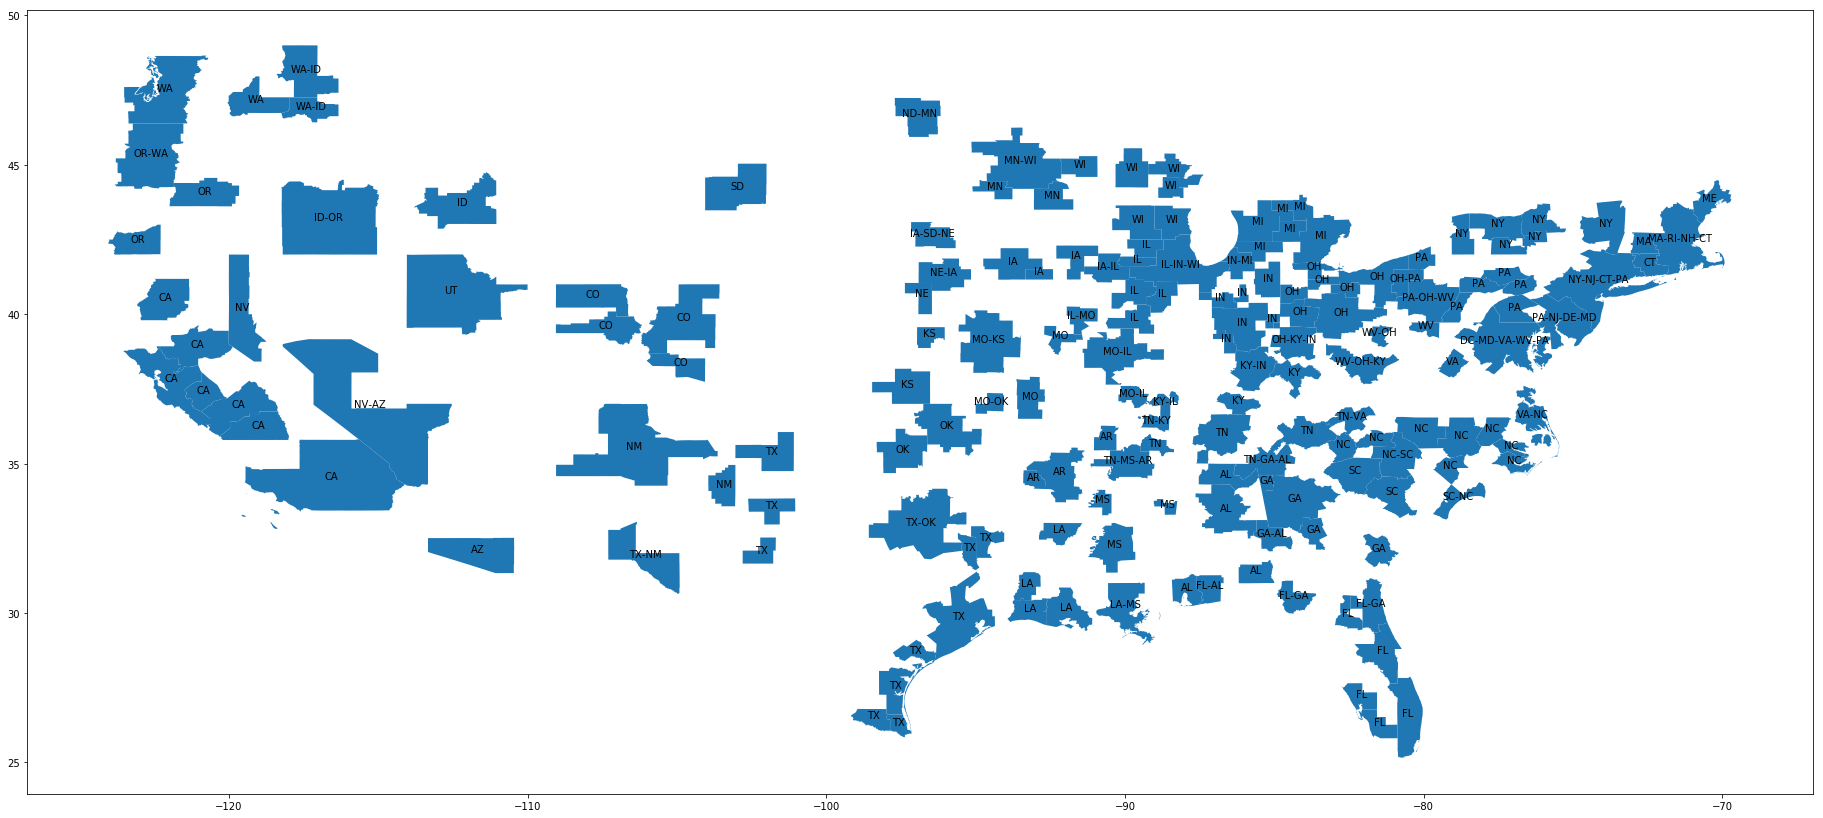

In [4]:
path_shp = './data/csa/cb_2017_us_csa_500k.shp'
gdf = gpd.read_file(path_shp)
gdf['state'] = gdf.NAME.str.extract(', (.+)$')[0]
gdf = gdf[~gdf.state.isin({'PR', 'HI', 'AK'})]

ax = gdf.plot(figsize=(32, 16))
for _, row in gdf.iterrows():
    plt.annotate(s=row.state, xy=row.geometry.centroid.coords[0], horizontalalignment='center')

# CBSA

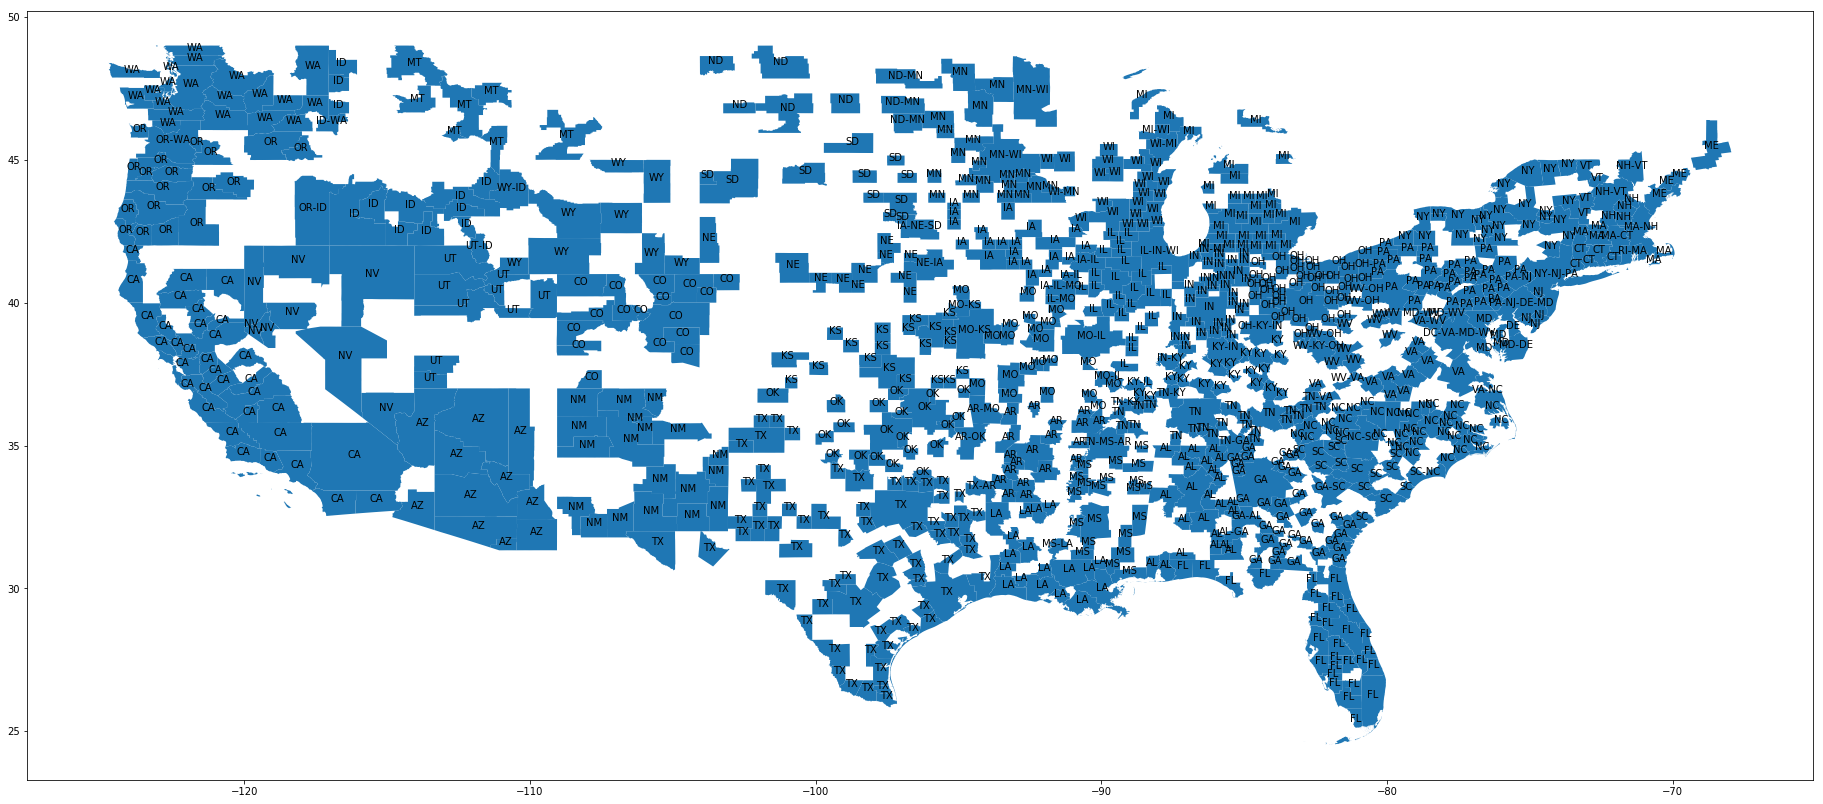

In [7]:
path_shp = './data/cbsa/cb_2017_us_cbsa_500k.shp'
gdf = gpd.read_file(path_shp)
gdf['state'] = gdf.NAME.str.extract(', (.+)$')[0]
gdf = gdf[~gdf.state.isin({'PR', 'HI', 'AK'})]

ax = gdf.plot(figsize=(32, 16))
for _, row in gdf.iterrows():
    plt.annotate(s=row.state, xy=row.geometry.centroid.coords[0], horizontalalignment='center')